# Credit Card Customer Segmentation With K-Means Unsupervised Machine Learning Algorithm

In this project, we'll step into the role of a data scientist at a credit card company, where the primary objective is to segment the company's clients into distinct groups. The aim is to enable the company to craft tailored business strategies that cater to the unique needs and behaviors of each customer segment.

I'll be using K-Means clustering for the analysis.

The project will involve several key steps:

- Exploratory Data Analysis (EDA)
- Feature Engineering
- Data Scaling
- Selecting Optimal Cluster Value
- Analyzing Results

Let's begin by importing the necessary libraries.

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# hide warnings
import warnings
warnings.filterwarnings('ignore')


## Exploratory Data Analysis
We'll download our dataset and do some EDA to get a better understanding of the data and ensure it is clean (no missing values, outlier-free).

In [2]:
# import files from computer
from google.colab import files
uploaded = files.upload()

Saving customer_segmentation.csv to customer_segmentation (1).csv


In [3]:
customers = pd.read_csv('customer_segmentation.csv')

In [5]:
print(customers.shape)
customers.head()

(10127, 14)


,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

We won't need the `customer_id` column for our analysis so we'll ignore it for now.

Of the 13 columns left, eight contain integers, two contain floats, and three contain strings, which means we have three categorical columns to deal with.

Note: there are no missing values.

In [7]:
for col in ['gender', 'education_level', 'marital_status']:
    print(customers[col].value_counts(), end='\n\n')

gender
F    5358
M    4769
Name: count, dtype: int64

education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: count, dtype: int64

marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64



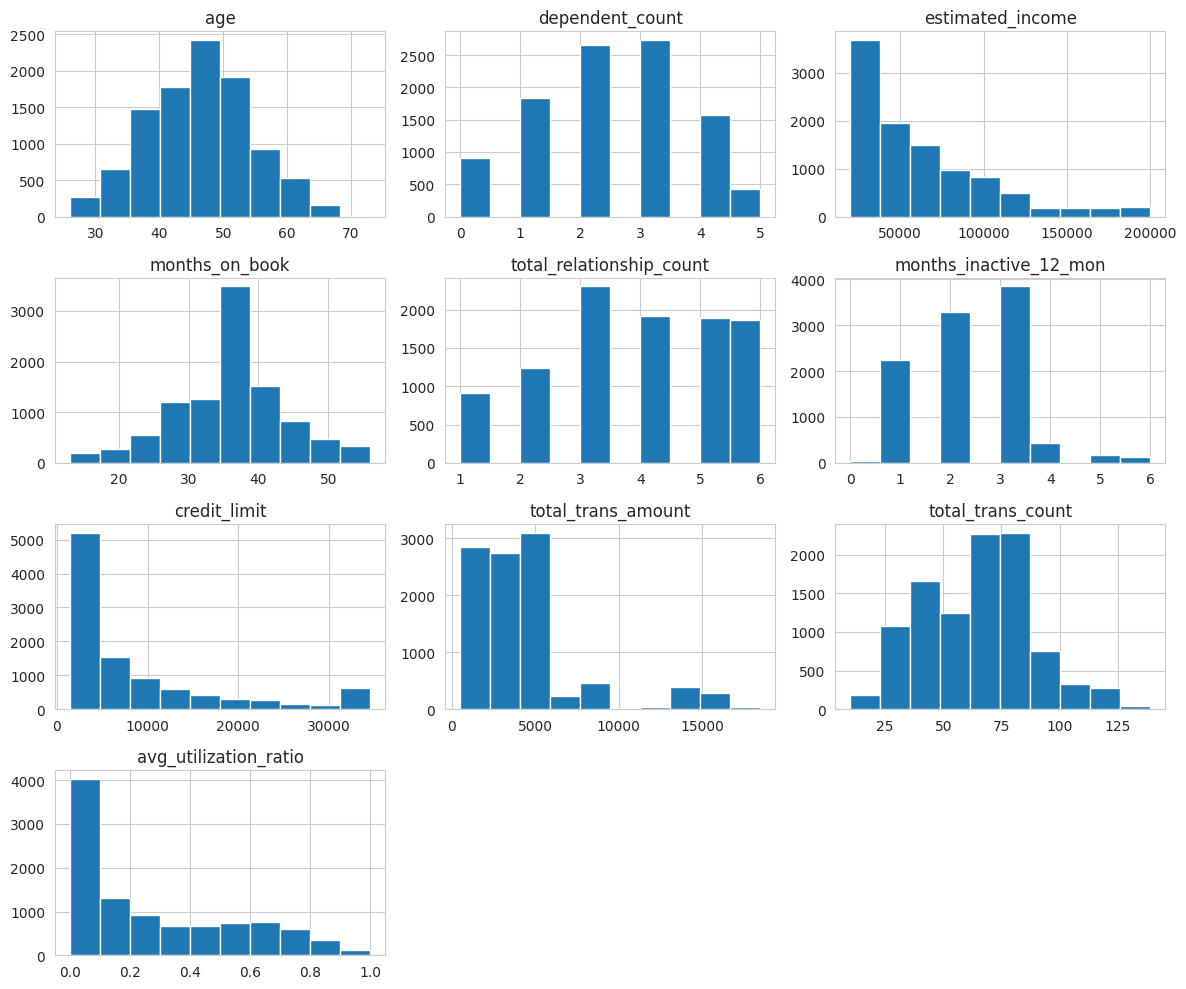

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))

# removing  customer_id before plotting the distributions
customers.drop('customer_id', axis=1).hist(ax=ax)

plt.tight_layout()
plt.show()

We don't have any glaring outliers so we're free to continue.




## Feature Engineering
We need to update our three categorical columns so they can be included in our clustering process.

For `gender`, we'll simply map the male and female values to 1s and 0s.

`Education_level` is ordinal we can do the same, mapping uneducated to 0 up to 5 for doctorate.

Since our `marital_status` column has no inherent order, we will use one-hot encoding to create dummy variables so the information is not lost.





In [9]:
# creating copy of dataset
customers_modif = customers.copy()

# updating gender and education_level columns
customers_modif['gender'] = customers_modif['gender'].map({'F': 0, 'M': 1})
customers_modif['education_level'] = customers_modif['education_level'].map({'Uneducated': 0, 'High School': 1, 'College': 2, 'Graduate': 3, 'Post-Graduate': 4, 'Doctorate': 5})

In [10]:
# updating marital_status column into dummy variables
dummies = pd.get_dummies(customers_modif[['marital_status']], drop_first=True)

customers_modif = pd.concat([customers_modif, dummies], axis=1)
customers_modif.drop(['marital_status'], axis=1, inplace=True)

print(customers_modif.shape)
customers_modif.head()

(10127, 16)


,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,True,False,False
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,False,True,False
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,True,False,False
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,False,False,True
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,True,False,False


## Data Scaling
In K-means clustering, it's crucial to scale the data because the algorithm relies on calculating distances between data points to form clusters. If our features are on different scales, like `estimated_income` in the thousands and `dependent_count` from 1 to 5, those with larger ranges will dominate the distance calculations. This can lead to distorted clusters that don't accurately reflect the true relationships in our data. By scaling the features to the same range, we ensure that each feature contributes equally to the distance calculations, resulting in more accurate and meaningful clusters.


In [11]:
X = customers_modif.drop('customer_id', axis=1)

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled

array([[-0.16540558,  1.05995565,  0.50336813, ...,  1.07733799,
        -0.79850685, -0.28260887],
       [ 0.33357038, -0.9434357 ,  2.04319867, ..., -0.92821381,
         1.2523374 , -0.28260887],
       [ 0.58305837,  1.05995565,  0.50336813, ...,  1.07733799,
        -0.79850685, -0.28260887],
       ...,
       [-0.29014957, -0.9434357 , -1.03646242, ...,  1.07733799,
        -0.79850685, -0.28260887],
       [-2.03656544,  1.05995565, -0.26654715, ..., -0.92821381,
        -0.79850685,  3.53845931],
       [-0.41489356, -0.9434357 , -0.26654715, ...,  1.07733799,
        -0.79850685, -0.28260887]])

## Selecting Optimal Cluster Value
It's time to decide on the number of clusters. We'll run the K-means algorithm considering a range from 1 to 10 possible Ks and store the results. Then, we'll plot the elbow curve that will help us find a final K.



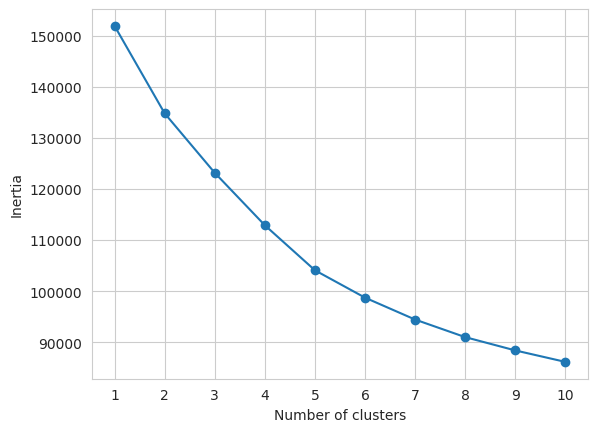

In [12]:
X = pd.DataFrame(X_scaled)
inertias = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    y = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.show()

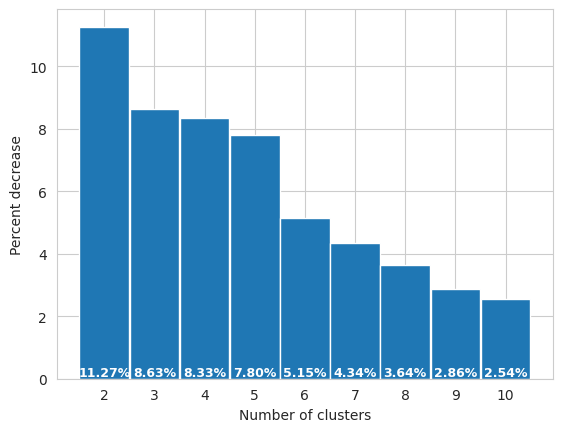

In [13]:
# calculate the percentage decrease from the previous inertia
percent_decrease = []
for i in range(1, len(inertias)):
    decrease = inertias[i-1] - inertias[i]
    percent = (decrease / inertias[i-1]) * 100
    percent_decrease.append(percent)

# plotting vertical bars
bars = plt.bar(range(2, 11), percent_decrease,width=.99)

# adding labels at the base of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(i+2, 0, f'{percent_decrease[i]:.2f}%',
             ha='center', va='bottom', color='white', fontsize=9, fontweight='bold',fontstretch=1)

plt.xlabel('Number of clusters')
plt.ylabel('Percent decrease')
plt.xticks(range(2, 11))
plt.show()


There isn't a clear "elbow" in the data but there is a fairly sizeable decrease in inertia from 5 to 6 clusters, so we'll use 5.

In [14]:
# running model with 5 clusters
model = KMeans(n_clusters=5)
y = model.fit_predict(X_scaled)

y

array([3, 1, 3, ..., 4, 0, 4], dtype=int32)

## Analyzing Results

Let's add our clusters into our original dataset and see our results.

In [17]:
customers['cluster'] = y + 1
customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,cluster
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,4
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,2
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,4
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,1
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,5


In [18]:
customers['cluster'].value_counts()

,count
cluster,
5,3458
2,2999
4,1974
3,964
1,732


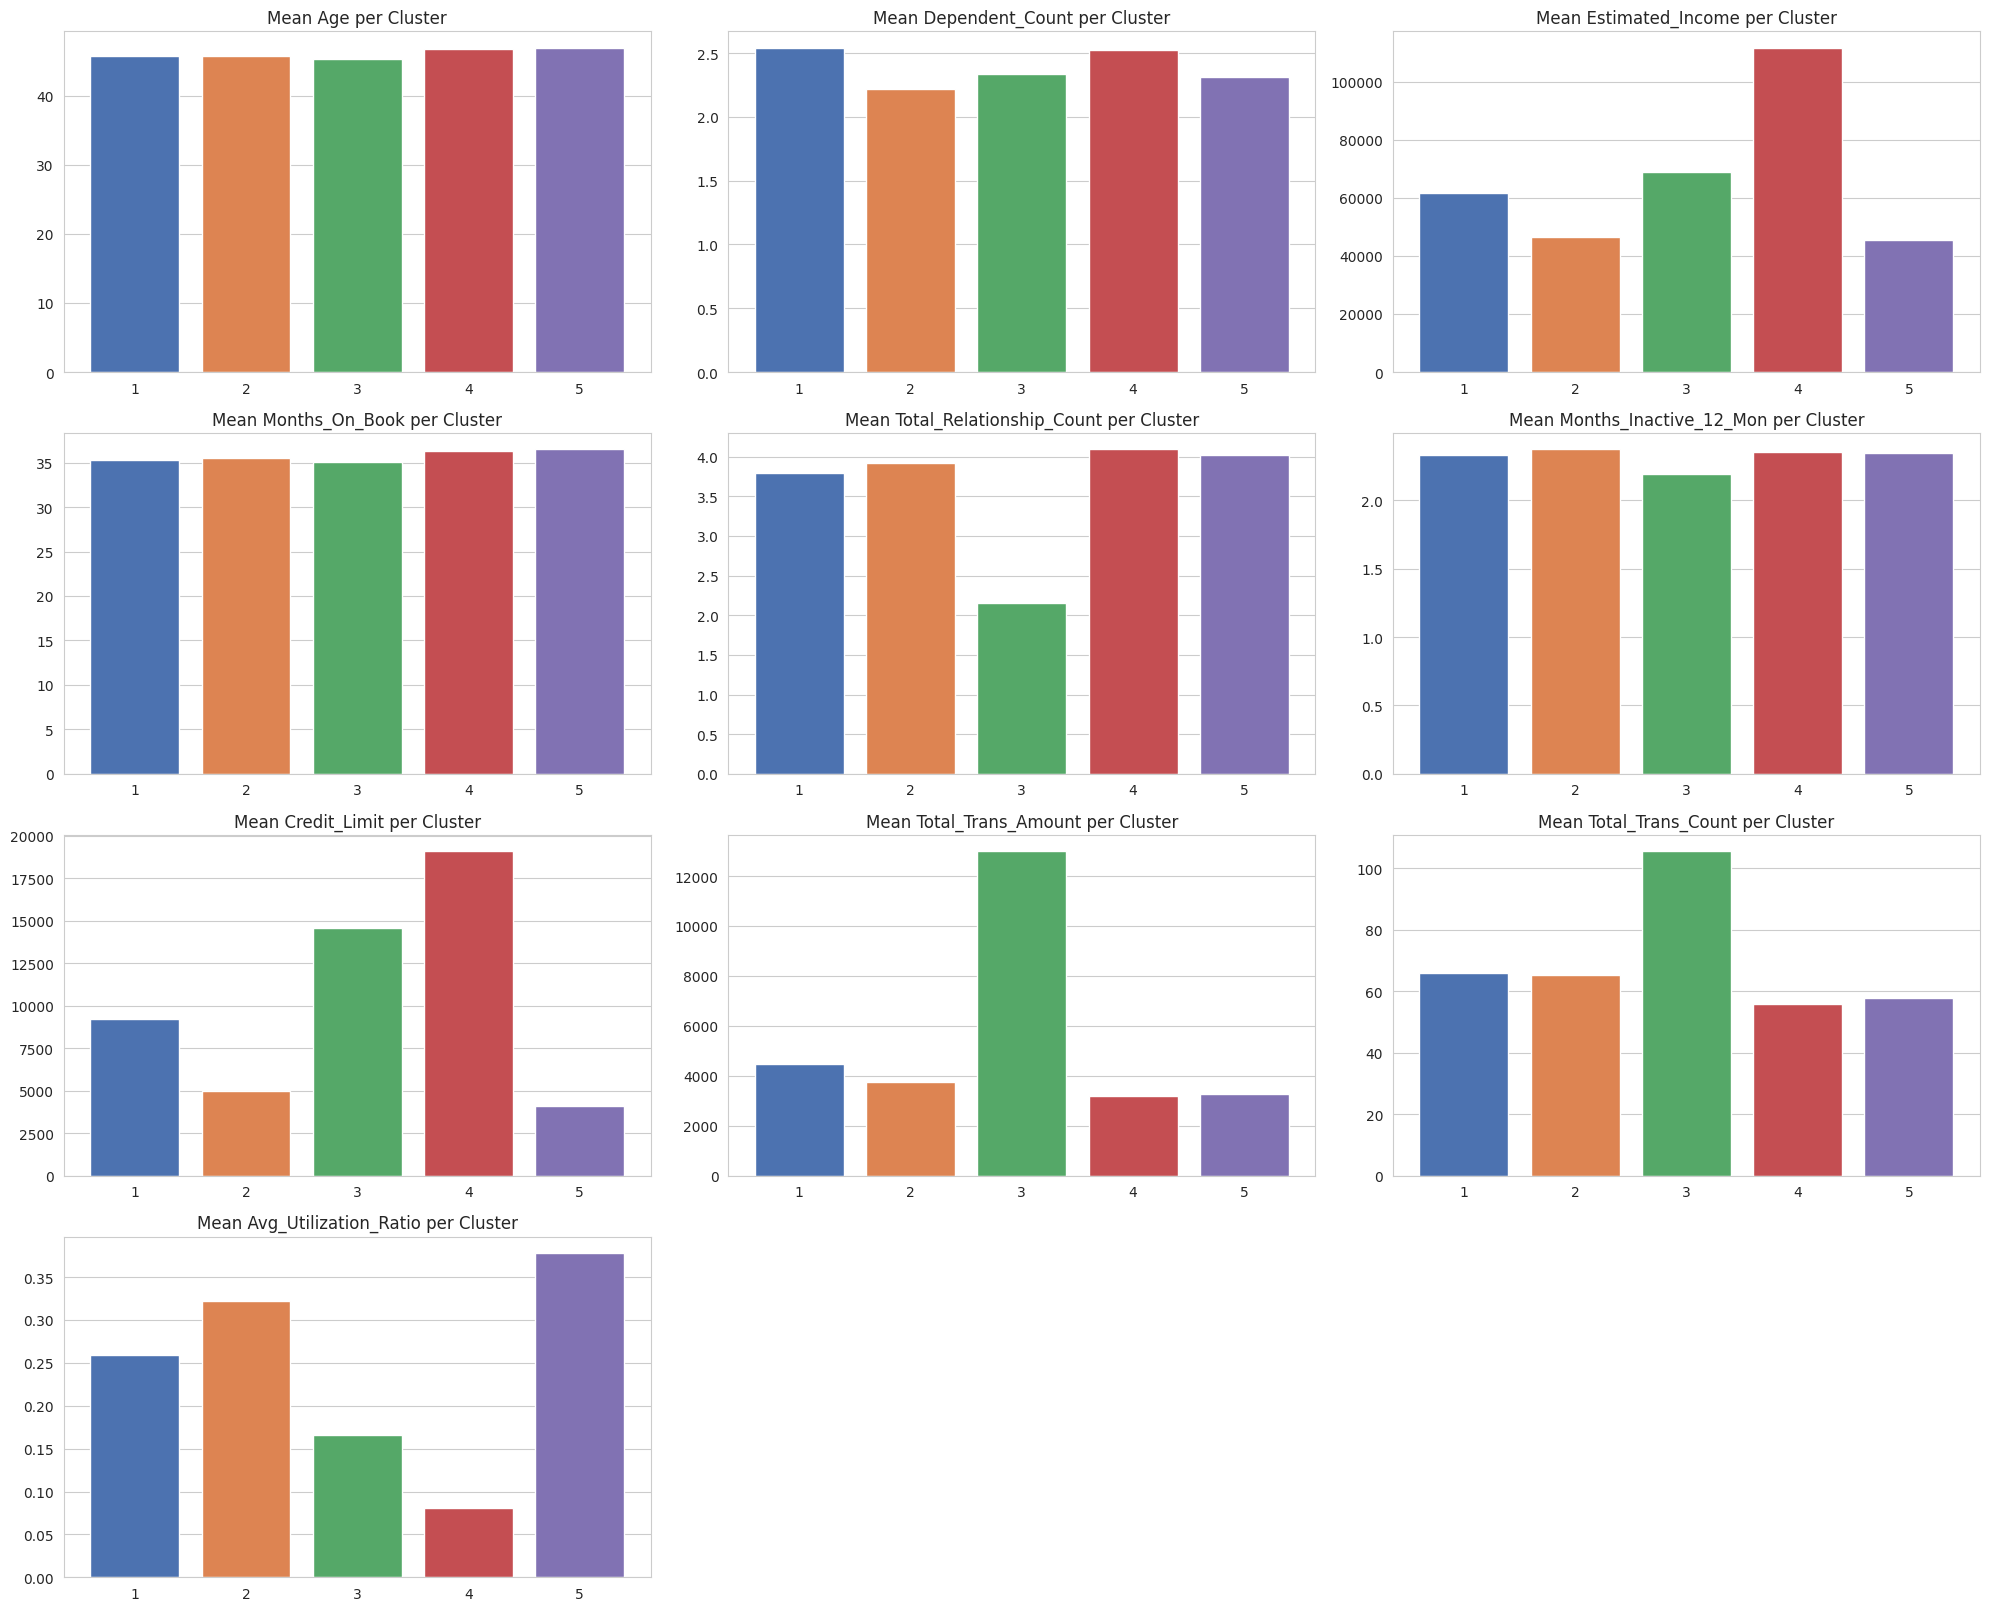

In [19]:
# selecting numeric columns for plotting
numeric_columns = customers.select_dtypes(include=np.number).drop(['customer_id', 'cluster'], axis=1).columns

fig = plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_columns):
    df_plot = customers.groupby('cluster')[column].mean()
    ax = fig.add_subplot(5, 3, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('deep'))
    ax.set_title(f'Mean {column.title()} per Cluster')
    ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

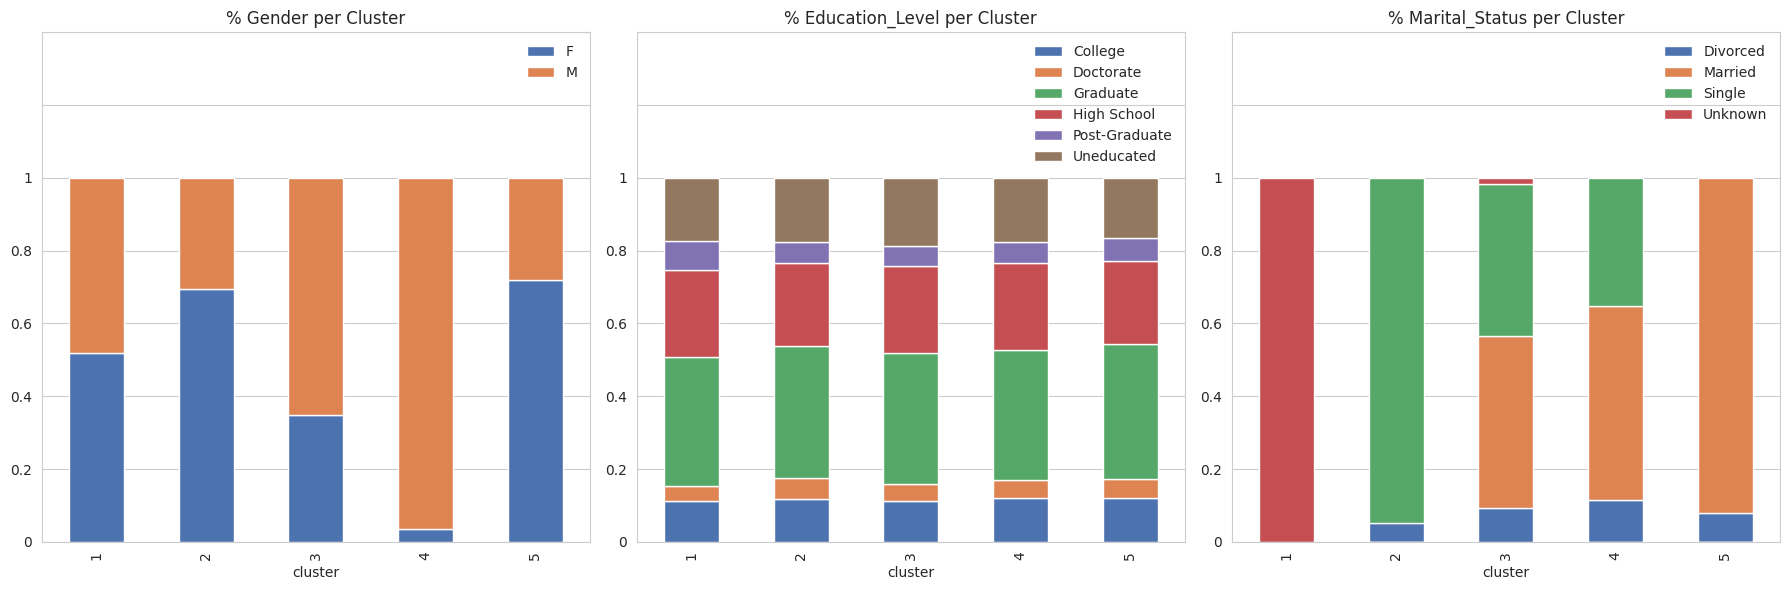

In [20]:
# selecting categorical columns for plotting
cat_columns = customers.select_dtypes(include=['object'])

fig = plt.figure(figsize=(18, 6))
for i, col in enumerate(cat_columns):
    plot_df = pd.crosstab(index=customers['cluster'], columns=customers[col], values=customers[col], aggfunc='size', normalize='index')
    ax = fig.add_subplot(1, 3, i+1)
    plot_df.plot.bar(stacked=True, ax=ax, color=sns.color_palette('deep'))
    ax.set_title(f'% {col.title()} per Cluster')

    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    ax.xaxis.grid(False)

    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax.set_yticklabels(labels)

plt.tight_layout()
plt.show()

## Conclusion

When using K-means for high-dimensional analysis, not all features provide meaningful insights. In this case, `age`, `dependent_count`, `months_on_book`, `months_inactive_12_mon`, and `education_level` did not exhibit much difference between clusters.

With that, we were able to gain some significant insight into the makeup and behaviors of our clusters, in hopes of converting that to revenue.

### Characteristics:
**Cluster 1:**
Pretty average across the board, potentially clustered by marital status of "Unknown".

**Cluster 2:**
Mostly low-income, single men with low credit limits and high utilization rates, making them risky borrowers.

**Cluster 3:**
Big spenders, surprisingly low utilization ratios, reliable borrowers.

**Cluster 4:**
High-income, almost exclusively men. Have appropriately high credit limits but do not use their cards very much.

**Cluster 5:**
Mostly married, very risky borrowers. Very high utilization rates and low incomes.

### Insight:
While we did not uncover all useful information, as Cluster 1 should probably be ignored, we found some insights which may be put to use. While the groups do differ in some respects, Clusters 2 and 5 can be approached similarly, also true with Clusters 3 and 4.

While the specific marketing tactics may vary, Clusters 2 and 5 should be considered risky borrowers that would likely spend more if credit limits were increased.

With Clusters 3 and 4, the objective should be to incentize these borrowers to spend more, so adding additional benefits to their cards could be effective.

This is just a glimpse into the power of clustering, and with more data we could provide an even more nuanced understanding of the customers we serve.